In [ ]:
# default_exp funcs.merfish_comparison

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from decode_fish.imports import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
import torch.nn as nn
import torch.nn.functional as F
import torch.tensor as T
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

sys.path.append('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/istdeco/')

from istdeco import ISTDeco
from utils import random_codebook, random_image_stack
from codebook import Codebook
from starfish.image import Filter

sys.path.append('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/FQ/bardensr/')
import bardensr

import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

2021-09-17 09:59:47.849725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_13/start_mic:5000xpsf_noise:0.4/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_9a/old_new_format/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_11/seed:1xint_fac:0.1/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_1/old_loss:Truexmin_int_sig:1.0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_1/old_loss:False/train.yaml')
# csv_name = 'test'
# cfg.foci.n_foci_avg = 0

In [ ]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]
# cfg.run_name = 'test'

In [ ]:
crop_sz = 256
cfg.foci.n_foci_avg = 0
cfg.training.bs = 3
cfg.PSF.n_cols = 1
cfg.random_crop.crop_sz = crop_sz
cfg.data_path.image_shape = [16,1,crop_sz,crop_sz]
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 256, 256)
1 volumes


In [ ]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sim_2/old_loss:True/train.yaml')
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
import h5py
from decode_fish.funcs.routines import *

# with torch.no_grad():

#     x, local_rate, background = next(iter(decode_dl))
#     sim_vars = PointProcessUniform(local_rate*0 + 0.075,model.int_dist.int_conc, model.int_dist.int_rate, 
#                                    model.int_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(code_inds)).sample(from_code_book=True, phasing=cfg.exp_type.phasing)
#     xsim = micro(*sim_vars, add_noise=False)
#     xsimn = micro.noise(xsim, background).sample()

#     gt_vars = sim_vars[:-1]
#     gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

with h5py.File('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data1/dens_0.01_int_0.5.h5', 'r') as f:

    xsimn = f['frames'][()]
    gt_df = get_df_from_hdf5(f['locations']) 
        
with h5py.File('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data1/sim_2/dens_0.01_int_0.5.h5', 'r') as f:

    dec_df = get_df_from_hdf5(f['old_loss:False']['locations_int'])

In [ ]:
gt_df = get_code_from_ints(gt_df, code_ref, targets, int_str='', p_str='')
gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

In [ ]:
post_proc.samp_threshold = 0.5

In [ ]:
with torch.no_grad():
    
    model.eval().cuda()
    res_dict = model(T(xsimn).cuda())
    res_dict = model.tensor_to_dict(res_dict)
    pred_df = post_proc.get_df(res_dict)
    pred_df = get_code_from_ints(pred_df, code_ref, targets, func=vcorrcoef, int_str='', p_str='p_')
    pred_df = exclude_borders(pred_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

In [ ]:
# sub_df = percentile_filter(pred_df, 80, 'p_code_err')
perf, matches, _  = matching(gt_df, pred_df, match_genes=False)
sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches)

Recall: 0.948
Precision: 0.981
Jaccard: 93.096
RMSE_vol: 13.988
Eff_3d: 90.172
FN: 96.0 FP: 34.0
Num. matches: 1753.000
Shift: -0.37,0.22,0.00


0.003993154592127781

1849
tensor(1949.2300, device='cuda:0') None


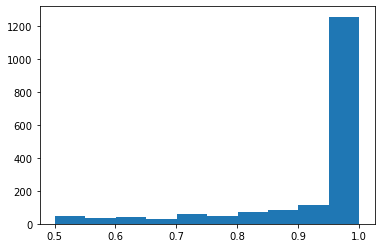

In [ ]:
plt.hist(pred_df['prob'])
print(torch.sigmoid(res_dict['logits']).sum(), print(len(gt_df)))

In [ ]:
# sub_df = percentile_filter(pred_df, 80, 'p_code_err')
perf, matches, _  = matching(gt_df, pred_df, match_genes=True)
sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches)

Recall: 0.778
Precision: 0.856
Jaccard: 68.800
RMSE_vol: 26.057
Eff_3d: 66.189
FN: 395.0 FP: 234.0
Num. matches: 1387.000
Shift: 2.39,0.28,0.00


1.0

In [ ]:
# export
def get_istdeco_df(sim_data, codebook, psf_sig=(1.7, 1.7), n_iter=100, bg=100.):
    
    istd_results = pd.DataFrame()
    
    n_rounds = codebook.shape[1]
    n_cols = codebook.shape[2]
    
    for i in range(len(sim_data)):

        image_data = sim_data[i,:,0]
        image_data = image_data.reshape([n_rounds,n_cols,image_data.shape[-2],image_data.shape[-1]], order='F')
        
        init_th = np.percentile(image_data,50)

        istdeco_model = ISTDeco(image_data, codebook, psf_sig, b=bg)
        X, Q, loss = istdeco_model.run(niter=n_iter)

        # Get codes
        code_id, y, x = np.where(np.logical_and(X>init_th,Q>0.1))

        intensity = X[code_id, y, x]
        quality = Q[code_id, y, x]

        # Store in dataframe
        df = pd.DataFrame(data={
                'frame_idx': i,
                'x': x.astype('float')+0.5, 
                'y': y.astype('float')+0.5,
                'z': 0.5,
                'intensity': intensity, 
                'quality': quality,
                'code_inds': code_id
        })

        istd_results = istd_results.append(df)

    istd_results = px_to_nm(istd_results)

    return istd_results

In [ ]:
istd_df = get_istdeco_df(xsimn, code_ref.reshape([140,8,2], order='F'), psf_sig=(1.7, 1.7), n_iter=400)
istd_df = exclude_borders(istd_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

In [ ]:
len(sub_df)

1786

In [ ]:
sub_df = istd_df[istd_df['quality'] > 0.35]
sub_df = sub_df[sub_df['intensity'] > 750]
perf, matches, _  = matching(gt_df, sub_df, match_genes=True, print_res=True)
sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches)

Recall: 0.953
Precision: 0.951
Jaccard: 90.904
RMSE_vol: 46.041
Eff_3d: 75.248
FN: 83.0 FP: 87.0
Num. matches: 1699.000
Shift: 0.48,-0.04,0.00


1.0

In [ ]:
perf, matches, _  = matching(gt_df, sub_df, match_genes=False, print_res=True)
sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches)

Recall: 0.924
Precision: 0.951
Jaccard: 88.191
RMSE_vol: 74.208
Eff_3d: 61.062
FN: 703.0 FP: 438.0
Num. matches: 8521.000
Shift: -0.42,-0.23,0.00


0.8579978875718812

In [ ]:
istd_df = get_istdeco_df(xsimn, code_ref.reshape([140,8,2], order='F'), psf_sig=(1.7, 1.7), n_iter=400)
istd_df = exclude_borders(istd_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

q_max = 0.3*istd_df['quality'].max()
i_max = 0.3*istd_df['intensity'].max()
i_min = istd_df['intensity'].min()

def objective(trial):
    
    n_iter = 400 # trial.suggest_uniform('n_iter', 50, 500)
    psf_s = 1.7 # trial.suggest_uniform('psf_s', 1.5, 2.0)
    
#     istd_df = get_istdeco_df(xsimn, code_ref.reshape([140,8,2], order='F'), psf_sig=(psf_s, psf_s), n_iter=int(n_iter))
#     istd_df = exclude_borders(istd_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])
    
    qual_th = trial.suggest_uniform('qual_th', 0.1, q_max)
    int_th = trial.suggest_uniform('int_th', i_min, i_max)
    
    sub_df = istd_df[(istd_df['intensity'] > int_th) & (istd_df['quality'] > qual_th)]
    perf, matches, _  = matching(gt_df, sub_df, match_genes=True, print_res=False) 
    
    return -perf['jaccard']

study = optuna.create_study()
study.optimize(objective, n_trials=200)

print(study.best_params)
print('Jaccard ', -study.best_value)

In [ ]:
sub_df = istd_df[(istd_df['intensity'] > study.best_params['int_th']) & (istd_df['quality'] > study.best_params['qual_th'])]
perf, matches, _  = matching(gt_df, sub_df, match_genes=True, print_res=False) 

In [ ]:
# export
def get_bardensr_tensor(sim_data, codebook, bg=100., n_iter=400, l1_pen=0.):
    
    bard_results = pd.DataFrame()
    evd_tensors = []
    codeflat = codebook.T
    
    for i in range(len(sim_data)):
    
        image_data = sim_data[i]
        Xnorm = image_data - bg
        Xnorm /= Xnorm.max()
        
#         Xnorm = bardensr.preprocessing.minmax(image_data - bg)

#         Xnorm = bardensr.preprocessing.minmax(image_data)
#         Xnorm = bardensr.preprocessing.background_subtraction(Xnorm,[0,10,10])
#         Xnorm = bardensr.preprocessing.minmax(Xnorm)

        evidence_tensor_iterative,extra_learned_params=\
            bardensr.spot_calling.estimate_density_iterative(Xnorm.astype('float64'),codeflat,l1_penalty=l1_pen,use_tqdm_notebook=True,iterations=n_iter, estimate_codebook_gain=False, psf_radius=(0, 0, 0))

#         evidence_tensor_iterative= bardensr.spot_calling.estimate_density_singleshot(Xnorm.astype('float64'), codeflat, noisefloor=0.05)
    
        evd_tensors.append(evidence_tensor_iterative)
        
    return evd_tensors

def get_bardensr_df(evd_tensors, th, ps=1.0):
    
    bard_results = pd.DataFrame()

    for i in range(len(evd_tensors)):    
    #     thresh_iterative=evd_tensors[i].max()*.1
        result_iterative=bardensr.spot_calling.find_peaks(evd_tensors[i],th, poolsize=(ps,ps,ps))

        code_inds = np.array(result_iterative.j.values, dtype=np.int16)
        df = pd.DataFrame(data={
                    'frame_idx': i,
                    'x': result_iterative.m2.values + 0.5, 
                    'y': result_iterative.m1.values + 0.5,
                    'z': 0.5,
                    'intensity': result_iterative.int.values,
                    'code_inds': code_inds
            })

        bard_results = bard_results.append(df)

    bard_results = px_to_nm(bard_results)
    return bard_results

In [ ]:
evd_tensors = get_bardensr_tensor(xsimn, code_ref, n_iter=1000, l1_pen=.05, bg=100.)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
bard_df = get_bardensr_df(evd_tensors, .7, ps=1.)
bard_df = exclude_borders(bard_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

In [ ]:
perf, matches, _  = matching(gt_df, bard_df, match_genes=True)
sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches)

Recall: 0.039
Precision: 0.948
Jaccard: 3.905
RMSE_vol: 67.918
Eff_3d: -1.919
FN: 8863.0 FP: 20.0
Num. matches: 361.000
Shift: -3.30,-3.72,0.00


1.0

In [ ]:
perf, matches, _  = matching(gt_df, bard_df, match_genes=True)
sum(matches['code_inds_pred'] == matches['code_inds_tar'])/len(matches)

Recall: 0.709
Precision: 0.767
Jaccard: 58.378
RMSE_vol: 68.890
Eff_3d: 45.974
FN: 2681.0 FP: 1984.0
Num. matches: 6543.000
Shift: 0.56,-1.14,0.00


1.0

In [ ]:
# bard_results = pd.DataFrame()

# for i in range(len(evd_tensors)):    
# #     thresh_iterative=evd_tensors[i].max()*.1
#     result_iterative=bardensr.spot_calling.find_peaks(evd_tensors[i],0.25, poolsize=(1.0,1.0,1.0))
    
#     code_inds = np.array(result_iterative.j.values, dtype=np.int16)
#     df = pd.DataFrame(data={
#                 'frame_idx': i,
#                 'x': result_iterative.m2.values + 0.5, 
#                 'y': result_iterative.m1.values + 0.5,
#                 'z': 0.5,
#                 'intensity': result_iterative.int.values,
#                 'code_inds': code_inds,
#                 'gene': targets[code_inds].ravel()
#         })
    
#     bard_results = bard_results.append(df)
    
# bard_results = px_to_nm(bard_results)
# bard_results = exclude_borders(bard_results, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

In [ ]:
evd_tensors = get_bardensr_tensor(xsimn, code_ref, n_iter=int(300), l1_pen=0.01)

def objective(trial):
    
#     n_iter = 300
#     l1_pen = trial.suggest_uniform('l1_pen', 0., 0.1)
    th     = trial.suggest_uniform('th', 0.1, 0.5)
    ps     = trial.suggest_uniform('ps', 0.1, 1.5)
    
#     evd_tensors = get_bardensr_tensor(xsimn, code_ref, n_iter=int(n_iter), l1_pen=l1_pen)
#     print(evd_tensors[0].mean())
    bard_df = get_bardensr_df(evd_tensors, th, ps)
    bard_df = exclude_borders(bard_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])
    
    perf, matches, _  = matching(gt_df, bard_df, match_genes=True, print_res=False) 
    
    return -perf['jaccard']

study = optuna.create_study()
study.optimize(objective, n_trials=200)

print(study.best_params)
print('Jaccard ', -study.best_value)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

[I 2021-09-17 12:03:32,271] A new study created in memory with name: no-name-0444ac95-7572-44e2-8419-846cbac274ca
[I 2021-09-17 12:03:51,881] Trial 0 finished with value: -0.15474322405709606 and parameters: {'th': 0.2604584383854186, 'ps': 0.6927663132468188}. Best is trial 0 with value: -0.15474322405709606.
[I 2021-09-17 12:04:14,227] Trial 1 finished with value: -0.10594050139593864 and parameters: {'th': 0.34764175889230753, 'ps': 0.3445239071416411}. Best is trial 0 with value: -0.15474322405709606.
[I 2021-09-17 12:04:24,844] Trial 2 finished with value: -0.333281647156511 and parameters: {'th': 0.16774441704114512, 'ps': 1.058708129030902}. Best is trial 2 with value: -0.333281647156511.
[I 2021-09-17 12:04:32,081] Trial 3 finished with value: -0.14364713532819529 and parameters: {'th': 0.48471157845729806, 'ps': 0.13452343949822448}. Best is trial 2 with value: -0.333281647156511.
[I 2021-09-17 12:04:40,756] Trial 4 finished with value: -0.22241068431809827 and parameters: {'t

[I 2021-09-17 12:09:49,306] Trial 39 finished with value: -0.4948711625977389 and parameters: {'th': 0.23587166208375115, 'ps': 1.2903695273003868}. Best is trial 26 with value: -0.5886926292792591.
[I 2021-09-17 12:09:53,099] Trial 40 finished with value: -0.5885045678449546 and parameters: {'th': 0.3320012361674086, 'ps': 1.4071281067360788}. Best is trial 26 with value: -0.5886926292792591.
[I 2021-09-17 12:09:57,020] Trial 41 finished with value: -0.5866276542143308 and parameters: {'th': 0.32588471649569145, 'ps': 1.3837917416466752}. Best is trial 26 with value: -0.5886926292792591.
[I 2021-09-17 12:10:00,426] Trial 42 finished with value: -0.5803248992721138 and parameters: {'th': 0.36400502449412986, 'ps': 1.398367870670909}. Best is trial 26 with value: -0.5886926292792591.


KeyboardInterrupt: 

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted index.ipynb.
